In [77]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import datetime
import os


In [78]:
# import data
data_submissions = pd.read_pickle('data/submissions.pkl')

# convert timestamp to readable time
to_readable_time = lambda timestamp: datetime.datetime.fromtimestamp(timestamp).strftime("%d-%b-%Y (%H:%M:%S)")
data_submissions['readable_time'] = [to_readable_time(timestamp) for timestamp in data_submissions['created_utc']]


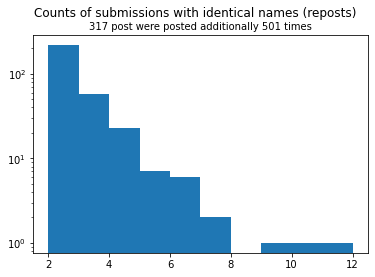

In [79]:
# get counts of submissions
titles, counts = np.unique(data_submissions['title'].to_numpy(), return_counts=True)
repost_titles = titles[ 1 < counts ]

# Plot of reposts
fig, ax = plt.subplots()

plt.suptitle('Counts of submissions with identical names (reposts)')
plt.title(f'{len(counts[ 1 < counts ])} post were posted additionally \
{sum(counts[1 < counts]) - len(counts[1 < counts])} times', fontsize=10)
ax.hist(counts[1 < counts])
ax.set_yscale('log')
plt.show()

In [82]:
# save partial data for analysis
pd.DataFrame(titles).to_csv('data/titles.csv')
pd.concat([data_submissions[data_submissions['title'] == title] for title in repost_titles]).to_csv('data/repsots.csv')